In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T

from torchinfo import summary

In [41]:
# Define params
BATCH_SIZE = 256
EPOCHS = 20

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [42]:
transformers = T.Compose([
    T.ToTensor()
])

In [43]:
train_dataset = torchvision.datasets.MNIST(root='./data/MNIST/', train=True, download=True, transform=transformers)
test_dataset = torchvision.datasets.MNIST(root='./data/MNIST/', train=False, download=True, transform=transformers)

In [44]:
train_dataloder = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_iter = iter(train_dataloder)
first_batch = next(train_iter)
images = first_batch[0]
labels = first_batch[1]

print(images.shape)
print(labels.shape)

torch.Size([256, 1, 28, 28])
torch.Size([256])


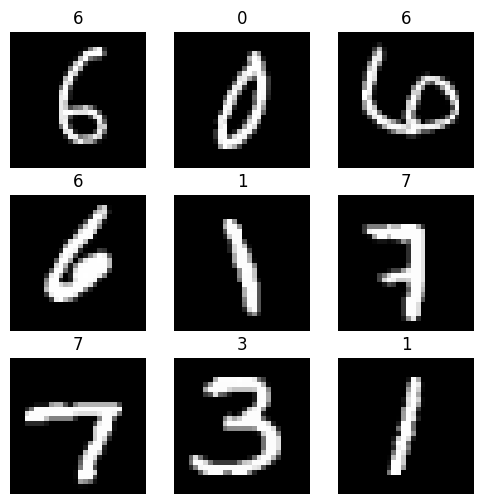

In [45]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(6,6))
cols, rows = 3, 3
for i in range(1, cols*rows +1):
    label = labels[i-1].item()
    img = images[i-1]
    figure.add_subplot(rows, cols, i)
    plt.axis('off')
    plt.title(label)
    plt.imshow(img.squeeze(), cmap='gray_r')

plt.show()

In [46]:
class Lenet5(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.c1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.s2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.c3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.s4 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.c5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)
        self.f6 = nn.Linear(in_features=120, out_features=84)
        self.squashing = nn.Tanh()
        self.f7 = nn.Linear(in_features=84, out_features=10)
    

    def forward(self, x):

        # feature extractor
        x = self.c1(x)
        x = self.s2(x)
        x = self.c3(x)
        x = self.s4(x)
        x = self.c5(x)

        # Flatten
        x = torch.flatten(x, 1)

        # classifier
        x = self.f6(x)
        x = self.squashing(x)
        x = self.f7(x)
        probs = F.softmax(x, dim=1)
        return probs

In [47]:
model = Lenet5().to(DEVICE)
summary(model, input_size=(BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Lenet5                                   [256, 10]                 --
├─Conv2d: 1-1                            [256, 6, 28, 28]          156
├─AvgPool2d: 1-2                         [256, 6, 14, 14]          --
├─Conv2d: 1-3                            [256, 16, 10, 10]         2,416
├─AvgPool2d: 1-4                         [256, 16, 5, 5]           --
├─Conv2d: 1-5                            [256, 120, 1, 1]          48,120
├─Linear: 1-6                            [256, 84]                 10,164
├─Tanh: 1-7                              [256, 84]                 --
├─Linear: 1-8                            [256, 10]                 850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
Total mult-adds (M): 108.30
Input size (MB): 0.80
Forward/backward pass size (MB): 13.35
Params size (MB): 0.25
Estimated Total Size (MB): 14.40

In [48]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)


In [49]:
def train(model, optim, train_dataloder):
    model.train()
    loss_sum = 0

    for data, target in train_dataloder:
        data, target = (data.to(DEVICE), target.to(DEVICE))
        
        optim.zero_grad()

        pred = model(data)
        loss = F.cross_entropy(pred, target)
        loss_sum += loss.item()

        # back propagation
        loss.backward()

        # step
        optim.step()

    loss_avg = loss_sum / len(train_dataloder.dataset)
    return loss_avg


In [50]:
def eval(model, test_dataloader):
    model.eval()

    loss_sum = 0
    correct = 0

    with torch.no_grad():
        for (data, target) in test_dataloader:
            data, target = (data.to(DEVICE), target.to(DEVICE))
            pred = model(data)
            loss = F.cross_entropy(pred, target)
            loss_sum += loss.item()

            label = pred.max(1, keepdim=True)[1]
            correct += label.eq(target.view_as(label)).sum().item()
    
    loss_avg = loss_sum / len(test_dataloader.dataset)
    accuary = 100. * correct / len(test_dataloader.dataset)
    return loss_avg, accuary



In [51]:
train_losses = []
eval_losses = []

for epoch in range(0, EPOCHS):
    train_loss = train(model, optimizer, train_dataloder)
    eval_loss, eval_accuracy = eval(model, test_dataloader)

    train_losses.append(train_loss)
    eval_losses.append(eval_loss)

    print('[{}] train loss: {:.4f} eval loss: {:.4f} accuracy {:.2f}%'.format(
        epoch, train_loss, eval_loss, eval_accuracy))


[0] train loss: 0.0090 eval loss: 0.0092 accuracy 19.89%
[1] train loss: 0.0089 eval loss: 0.0089 accuracy 48.99%
[2] train loss: 0.0074 eval loss: 0.0068 accuracy 80.43%
[3] train loss: 0.0064 eval loss: 0.0064 accuracy 89.45%
[4] train loss: 0.0062 eval loss: 0.0063 accuracy 90.18%
[5] train loss: 0.0062 eval loss: 0.0063 accuracy 91.23%
[6] train loss: 0.0061 eval loss: 0.0062 accuracy 91.72%
[7] train loss: 0.0061 eval loss: 0.0062 accuracy 92.12%
[8] train loss: 0.0061 eval loss: 0.0062 accuracy 92.83%
[9] train loss: 0.0061 eval loss: 0.0062 accuracy 92.99%
[10] train loss: 0.0060 eval loss: 0.0062 accuracy 93.33%
[11] train loss: 0.0060 eval loss: 0.0061 accuracy 93.73%
[12] train loss: 0.0060 eval loss: 0.0061 accuracy 93.76%
[13] train loss: 0.0060 eval loss: 0.0061 accuracy 94.01%
[14] train loss: 0.0060 eval loss: 0.0061 accuracy 94.32%
[15] train loss: 0.0060 eval loss: 0.0061 accuracy 94.39%
[16] train loss: 0.0060 eval loss: 0.0061 accuracy 94.52%
[17] train loss: 0.0060 

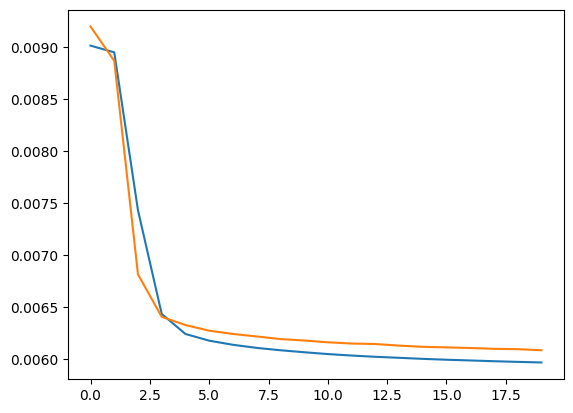

In [52]:
plt.plot(train_losses, label='train_loss')
plt.plot(eval_losses, label='eval_loss')
plt.show()

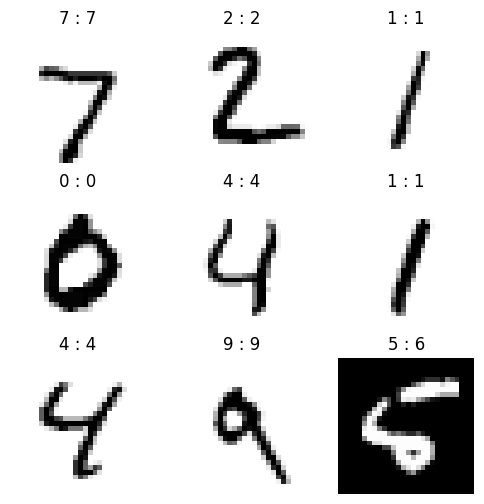

In [61]:
test_iter = iter(test_dataloader)
first_batch = next(test_iter)
images = first_batch[0]
labels = first_batch[1]

pred = model(images.to(DEVICE))

pred_labels = pred.max(1, keepdim=True)[1]
pred_labels = [x.item() for x in pred_labels ]

figure = plt.figure(figsize=(6,6))
cols, rows = 3, 3
for i in range(1, cols*rows +1):
    target_label = labels[i-1].item()
    pred_label = pred_labels[i-1]

    img = images[i-1]
    figure.add_subplot(rows, cols, i)
    plt.axis('off')
    plt.title('{} : {}'.format(target_label, pred_label))
    if target_label == pred_label:
        plt.imshow(img.squeeze(), cmap='gray_r')
    else:
        plt.imshow(img.squeeze(), cmap='gray')

plt.show()
